# Evaluate Data Quality Issues

1. Check Validity: data type checks (e.g., dates are in date format), range checks (e.g., prices are int, float), and list-of-values checks (e.g., categories match a predefined list)
2. Check Consistency: ensuring that all records adhere to logical rules. For instance, finishedDate should always be on or after createDate.
3. Check Completeness: Detect missing value
4. Check Integrity: Verify that relationships among data entities (tables) make sense. For example, duplicate should not exist.
5. Check Outliers: Identify and investigate any outliers that may indicate data entry errors or other anomalies

In [1]:
# import Required packages
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Function to read json file
def readJson(file_path):    
    # Open the gzipped file in text mode ('rt')
    with gzip.open(file_path, 'rt') as f:
        # Iterate over each line in the file
        all_data = []
        for line in f:
            
            try:
                # Find the starting index of the JSON part (assuming it always starts with '{"_id"')
                json_start_index = line.find('{"_id"')
                if json_start_index != -1:
                    # Extract the JSON part from the line
                    json_part = line[json_start_index:]
                    # Attempt to parse the JSON data
                    data = json.loads(json_part)
                    # If successful, append the parsed data to the 'users' list
                    all_data.append(data)
                else:
                    # If '{"_id"' is not found in the line, skip it
                    continue
            except json.JSONDecodeError:
                # If an error occurs while parsing the JSON, print the offending line (optional) and skip it
                print("Could not parse line:", line)
                continue
            data_df = pd.DataFrame(all_data)    
        return data_df

# Function to extract value from nested dictionary
def extract_value_from_dict(dict_col, key):
    return dict_col.apply(lambda x: x.get(key, None) if isinstance(x, dict) else None)

## a. Receipts Data

In [3]:
# Read Receipts Data
file_path = './receipts.json.gz'
receipts_df = readJson(file_path)
# Flatten nested '_id' and date columns
receipts_df['_id'] = extract_value_from_dict(receipts_df['_id'], '$oid')
receipts_df['createDate'] = pd.to_datetime(extract_value_from_dict(receipts_df['createDate'], '$date'), unit='ms')
receipts_df['dateScanned'] = pd.to_datetime(extract_value_from_dict(receipts_df['dateScanned'], '$date'), unit='ms')
receipts_df['finishedDate'] = pd.to_datetime(extract_value_from_dict(receipts_df['finishedDate'], '$date'), unit='ms')
receipts_df['modifyDate'] = pd.to_datetime(extract_value_from_dict(receipts_df['modifyDate'], '$date'), unit='ms')
receipts_df['pointsAwardedDate'] = pd.to_datetime(extract_value_from_dict(receipts_df['pointsAwardedDate'], '$date'), unit='ms')
receipts_df['purchaseDate'] = pd.to_datetime(extract_value_from_dict(receipts_df['purchaseDate'], '$date'), unit='ms')

In [4]:
receipts_df.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,5,2021-01-03 00:00:00,1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.00,5ff1e194b6a9d73a3a9f1052


### 1. Check Validity

In [5]:
def check_data_types(df):
    print(df.info())
    date_columns = ['createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'purchaseDate']
    for col in date_columns:
        if df[col].dtype != 'datetime64[ns]':
            print(f"Column {col} has invalid data type: {df[col].dtype}")

    if df['totalSpent'].dtype not in ['int64', 'float64']:
        # Convert 'totalSpent' column to float, coercing errors to NaN
        df['totalSpent'] = pd.to_numeric(df['totalSpent'], errors='coerce')

def check_range(df):
    # Check for non-negative values in 'totalSpent'
    if (df['totalSpent'] < 0).any():
        print("There are negative values in 'totalSpent' column")

# Call the functions
check_data_types(receipts_df)
check_range(receipts_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   _id                      1119 non-null   object        
 1   bonusPointsEarned        544 non-null    float64       
 2   bonusPointsEarnedReason  544 non-null    object        
 3   createDate               1119 non-null   datetime64[ns]
 4   dateScanned              1119 non-null   datetime64[ns]
 5   finishedDate             568 non-null    datetime64[ns]
 6   modifyDate               1119 non-null   datetime64[ns]
 7   pointsAwardedDate        537 non-null    datetime64[ns]
 8   pointsEarned             609 non-null    object        
 9   purchaseDate             671 non-null    datetime64[ns]
 10  purchasedItemCount       635 non-null    float64       
 11  rewardsReceiptItemList   679 non-null    object        
 12  rewardsReceiptStatus     1119 non-

### 2. Check Consistency

In [11]:
def check_consistency(df):
    inconsistent_dates = df[df['finishedDate'] < df['createDate']]
    if not inconsistent_dates.empty:
        print(f"Found {len(inconsistent_dates)} records where 'finishedDate' is before 'createDate'")
    else:
        print("No record where 'finishedDate' is before 'createDate")

# Call the function
check_consistency(receipts_df)

No record where 'finishedDate' is before 'createDate


### 3. Check Completeness

9 columns in Receipts Data contains missing value

In [7]:
def check_completeness(df):
    missing_values = df.isnull().sum()
    print("Missing values in each column:")
    print(missing_values[missing_values > 0])

check_completeness(receipts_df)

Missing values in each column:
bonusPointsEarned          575
bonusPointsEarnedReason    575
finishedDate               551
pointsAwardedDate          582
pointsEarned               510
purchaseDate               448
purchasedItemCount         484
rewardsReceiptItemList     440
totalSpent                 435
dtype: int64


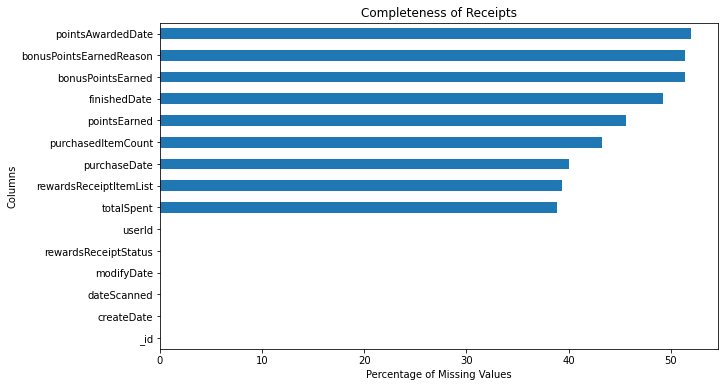

In [8]:
# Function to check completeness by calculating the percentage of missing values in each column
def check_completeness(df):
    completeness_report = df.isnull().mean() * 100
    return completeness_report

# Function to plot completeness for a given DataFrame in a horizontal bar plot
def plot_completeness(df, title):
    completeness_report = check_completeness(df)
    completeness_report = completeness_report.sort_values(ascending=True)
    completeness_report.plot(kind='barh', figsize=(10, 6))  # Changed to 'barh' for horizontal bars
    plt.title(f'Completeness of {title}')
    plt.xlabel('Percentage of Missing Values')  # Swapped the labels
    plt.ylabel('Columns')
    plt.show()

plot_completeness(receipts_df, 'Receipts')

### 4. Check Integrity

In [9]:
# Function to plot the number of duplicates in a DataFrame
def check_duplicates(df):
    duplicates = df['_id'].duplicated().sum()
    if duplicates:
        print(f'There are {duplicates} duplicates  for ID')
    else:
        print('There is no duplicate for ID')
check_duplicates(receipts_df)

There is no duplicate for ID


### 4. Check Integrity

In [12]:
# Check Integrity
def check_integrity(df, user_id):
    if df[user_id].isin(df[user_id]).all():
        print("All user IDs in receipts table correspond to valid users.")
    else:
        print("Error: Found user IDs in receipts that don't exist in users table.")
        
check_integrity(receipts_df, '_id')

All user IDs in receipts table correspond to valid users.


### 5. Check for Outliers
28 values in the totalSpent column were identified as outliers.
(Outliers are defined here as any values that are more than 15 IQRs below the first quartile or above the third quartile. This is a very aggressive criterion for outliers)

In [13]:
# Check for Outliers in 'totalSpent'
df = receipts_df
Q1 = df['totalSpent'].quantile(0.25)
Q3 = df['totalSpent'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['totalSpent'] < (Q1 - 15 * IQR)) | (df['totalSpent'] > (Q3 + 15 * IQR))]
print("Outliers in 'totalSpent':")
print(outliers)

Outliers in 'totalSpent':
                          _id  bonusPointsEarned  \
305  600373700a720f05f3000091              750.0   
306  60023e8f0a720f05f300008b              750.0   
310  6002590c0a7214ad4c000082              750.0   
314  60025cb80a720f05f300008d              750.0   
315  600370250a720f05f3000090              750.0   
318  600260210a720f05f300008f              750.0   
321  6004a5f20a7214ad4c000088              750.0   
324  60049d9d0a720f05f3000094              750.0   
327  6004a99e0a720f05f3000095              750.0   
360  60088a100a7214ad890000bd              750.0   
407  60099c3c0a7214ad89000135              750.0   
409  6009e72c0a720f0535000003              750.0   
419  600996ac0a720f05fa000134              750.0   
420  600b34ca0a7214ada200000c              750.0   
423  600a1a8d0a7214ada2000008              750.0   
425  600afbd90a720f053500000b              750.0   
426  600b420b0a7214ada200000d              750.0   
427  600af82f0a720f053500000a         

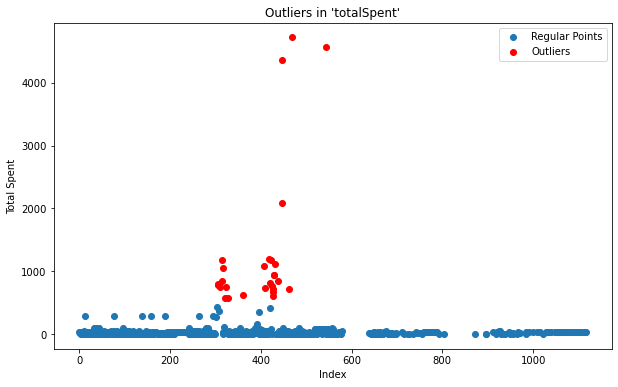

In [29]:
# Calculate IQR
Q1 = df['totalSpent'].quantile(0.25)
Q3 = df['totalSpent'].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers using 15 * IQR
outliers = df[(df['totalSpent'] < (Q1 - 15 * IQR)) | (df['totalSpent'] > (Q3 + 15 * IQR))]

# Plot
plt.figure(figsize=(10, 6))

# Plot non-outliers
plt.scatter(df.index[~df.index.isin(outliers.index)], df['totalSpent'][~df.index.isin(outliers.index)], label='Regular Points')

# Highlight outliers
plt.scatter(outliers.index, outliers['totalSpent'], color='red', label='Outliers')

plt.title("Outliers in 'totalSpent'")
plt.xlabel('Index')
plt.ylabel('Total Spent')
plt.legend()

plt.show()

## b. Users Data

In [16]:
# read Users Data
file_path = './users.json.gz'
users_df = readJson(file_path)
# Flatten nested '_id' and date columns
users_df['_id'] = extract_value_from_dict(users_df['_id'], '$oid')
users_df['createdDate'] = pd.to_datetime(extract_value_from_dict(users_df['createdDate'], '$date'), unit='ms')
users_df['lastLogin'] = pd.to_datetime(extract_value_from_dict(users_df['lastLogin'], '$date'), unit='ms')
users_df.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.596999936,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872,consumer,Email,WI


### 1. Check Validity

In [17]:
def check_data_types(df):
    print(df.info())
    date_columns = ['createdDate', 'lastLogin']
    for col in date_columns:
        if df[col].dtype != 'datetime64[ns]':
            print(f"Column {col} has invalid data type: {df[col].dtype}")
def check_roles(df):
    valid_roles = ['consumer', 'admin', 'fetch-staff']
    invalid_roles = df[~df['role'].isin(valid_roles)]
    return f'Count of Invalid roles: {len(invalid_roles)}'
# Call the functions
check_data_types(users_df)
check_roles(users_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   _id           495 non-null    object        
 1   active        495 non-null    bool          
 2   createdDate   495 non-null    datetime64[ns]
 3   lastLogin     433 non-null    datetime64[ns]
 4   role          495 non-null    object        
 5   signUpSource  447 non-null    object        
 6   state         439 non-null    object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 23.8+ KB
None


'Count of Invalid roles: 0'

In [20]:
### 2. Check Consistency
def check_consistency(df):
    inconsistent_dates = df[df['lastLogin'] < df['createdDate']]
    print(f"Found {len(inconsistent_dates)} records where 'lastLogin' is before 'createdDate'")

# Call the function
check_consistency(users_df)

Found 0 records where 'lastLogin' is before 'createdDate'


### 3. Check Completeness

In [19]:
check_completeness(users_df)

_id              0.000000
active           0.000000
createdDate      0.000000
lastLogin       12.525253
role             0.000000
signUpSource     9.696970
state           11.313131
dtype: float64

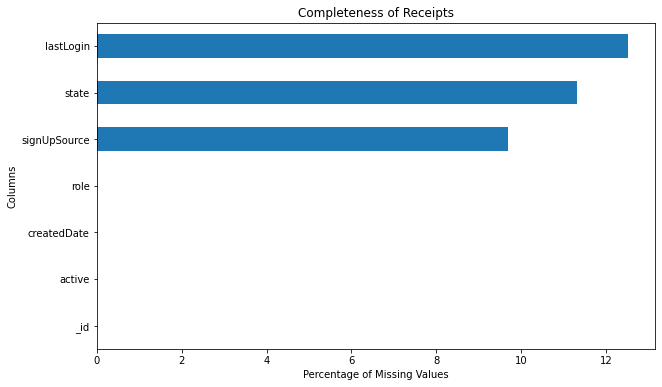

In [21]:
# Analyze percentage of missing values users
plot_completeness(users_df, 'Receipts')

### 4. Check Integrity

In [22]:
check_integrity(users_df, '_id')
check_duplicates(users_df)

All user IDs in receipts table correspond to valid users.
There are 283 duplicates  for ID


## Brand Data

In [23]:
file_path = './brands.json.gz'
brands_df = readJson(file_path)
# Flatten nested '_id'
brands_df['_id'] = extract_value_from_dict(brands_df['_id'], '$oid')
brands_df.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, ...",test brand @1612366101024,False,NaN
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...",Starbucks,False,STARBUCKS
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146176,False,TEST BRANDCODE @1612366146176
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146051,False,TEST BRANDCODE @1612366146051
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, ...",test brand @1612366146827,False,TEST BRANDCODE @1612366146827


### 1. Check Validity

In [24]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   _id           495 non-null    object        
 1   active        495 non-null    bool          
 2   createdDate   495 non-null    datetime64[ns]
 3   lastLogin     433 non-null    datetime64[ns]
 4   role          495 non-null    object        
 5   signUpSource  447 non-null    object        
 6   state         439 non-null    object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 23.8+ KB


### 2. Check Completeness

In [25]:
check_completeness(users_df)

_id              0.000000
active           0.000000
createdDate      0.000000
lastLogin       12.525253
role             0.000000
signUpSource     9.696970
state           11.313131
dtype: float64

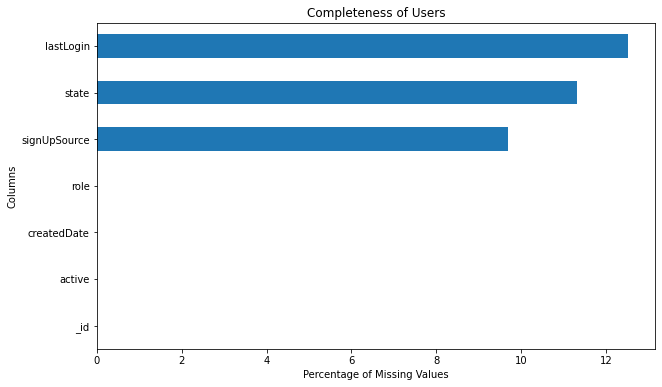

In [26]:
plot_completeness(users_df, 'Users')

### 4. Check Integrity

In [27]:
check_integrity(users_df, '_id')

All user IDs in receipts table correspond to valid users.
